# Mask R-CNN - part 3

Before you start:
 - Clone Mask_RCNN, install dependencies https://github.com/matterport/Mask_RCNN
 - Download weights of COCO model https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
 - Download COCO dataset from http://cocodataset.org/#download or at least the adnotations https://vision.ece.vt.edu/mscoco/coco/annotations/instances_train-val2014.zip

## Paths

Remember to change to your own...

In [1]:
import os

ROOT_DIR = os.path.abspath("../../varia/Mask_RCNN/")
MODEL_DIR = os.path.abspath("/data/coco/")
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
HIGHT, WIDTH = 442, 878
FRAME_TIME = 200

## Libraries

In [2]:
import sys
import random
import math

import numpy as np
import skimage.io

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
"""Import Mask R-CNN."""
sys.path.append(ROOT_DIR)
import mrcnn.utils
import mrcnn.model
import mrcnn.visualize

Using TensorFlow backend.


## Configuration

In [4]:
"""Load the configuration file for the MS-COCO model."""
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))
import coco


class InferenceConfig(coco.CocoConfig):
    """Owerwrite the batch size.
    
    Batch size = GPU_COUNT * IMAGES_PER_GPU
    For our needs, we need batch size = 1
    """
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.4

config = InferenceConfig()

In [5]:
"""Create a model object and load the weights."""
model = mrcnn.model.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [6]:
"""Check class numbers."""
dataset = coco.CocoDataset()
dataset.load_coco(MODEL_DIR, "train")
dataset.prepare()

loading annotations into memory...
Done (t=9.37s)
creating index...
index created!


## Filters

In [7]:
def filter_vehicles(detected_objects):
    """Skip boxes that do not indicate cars, buses or trucks.
    
    Cuco models ids are:
     - 3 car,
     - 4 motorcycle,
     - 6 bus,
     - 7 train,
     - 8 truck,
     - 9 boat.
    """
    mask = np.array([i in (3, 8, 6) for i in detected_objects['class_ids']], dtype=bool)
    
    vehicles = {
        'rois': detected_objects['rois'][mask],
        'class_ids': detected_objects['class_ids'][mask],
        'scores': detected_objects['scores'][mask],
        'masks': detected_objects['masks'][:,:,mask]
    }
    
    return vehicles

In [8]:
def filter_small_objects(detected_objects, treshold=0.001):
    """Skip boxes that are small."""
    size = lambda x: (x[2]-x[0])*(x[3]-x[1])
    size_x, size_y, _ = detected_objects['masks'].shape
    min_size = size_x*size_y*treshold
    
    mask = np.array([size(i) > min_size for i in detected_objects['rois']], dtype=bool)
    
    vehicles = {
        'rois': detected_objects['rois'][mask],
        'class_ids': detected_objects['class_ids'][mask],
        'scores': detected_objects['scores'][mask],
        'masks': detected_objects['masks'][:,:,mask]
    }
    
    return vehicles

## Times Square example once again

In [9]:
IMAGE_PATTERN = os.path.abspath("../resources/times-square-jpg-200ms/*.jpg")

images = skimage.io.imread_collection(IMAGE_PATTERN)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -103.90000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


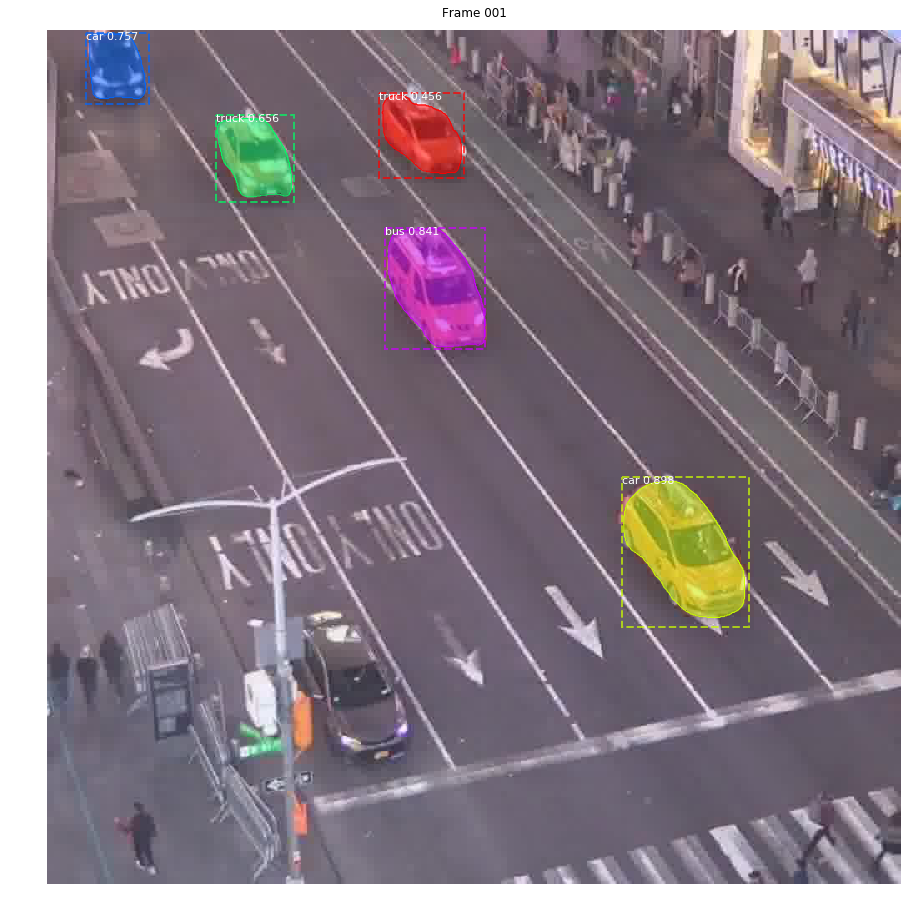

In [10]:
"""Load first frame."""

image = images[0]
results = model.detect([image], verbose=1)

r0 = results[0]
r0 = filter_vehicles(r0)
r0 = filter_small_objects(r0, treshold=0.002)

mrcnn.visualize.display_instances(
    image, r0['rois'], r0['masks'], r0['class_ids'], dataset.class_names, r0['scores'],
    title='Frame 001')

In [11]:
"""Return how many vehicles we detected."""
len(r0['class_ids'])

5

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -108.80000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


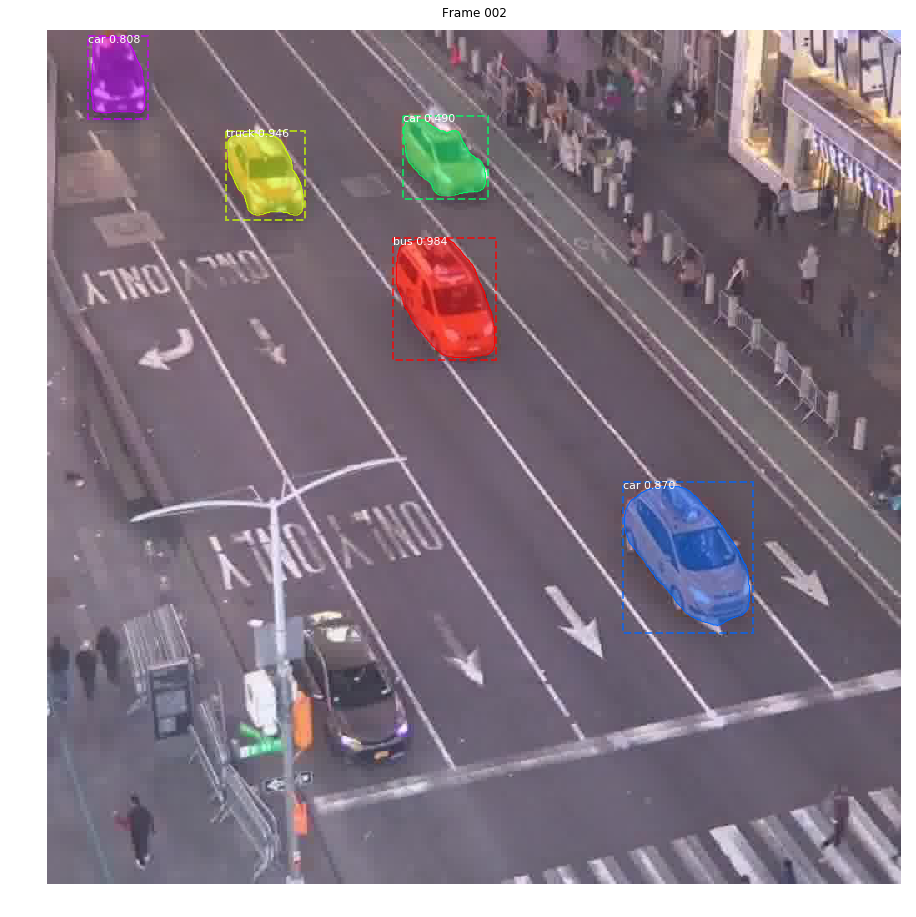

In [12]:
"""Load second frame."""

image = images[1]
results = model.detect([image], verbose=1)

r1 = results[0]
r1 = filter_vehicles(r1)
r1 = filter_small_objects(r1, treshold=0.002)

mrcnn.visualize.display_instances(
    image, r1['rois'], r1['masks'], r1['class_ids'], dataset.class_names, r1['scores'],
    title='Frame 002')

In [13]:
"""Return how many vehicles we detected."""
len(r1['class_ids'])

5

## Translation - test with two frames

In [14]:
"""Calculating overlap."""

overlaps = mrcnn.utils.compute_overlaps(r0['rois'], r1['rois'])
overlaps

array([[0.        , 0.        , 0.89058369, 0.        , 0.        ],
       [0.7117786 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.75193399, 0.        ],
       [0.        , 0.54317184, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.36623994]])

In [15]:
def translations(past, current, treshold=0.3):
    """Calculating vectors of translations."""
    center = lambda x: [(x[2] + x[0])/2, (x[3] + x[1])/2]
    
    overlaps = mrcnn.utils.compute_overlaps(past['rois'], current['rois'])
    
    result = []
    for i, row in enumerate(overlaps):
        max_index = row.argmax(axis=0)
        if row[max_index] < treshold:
            continue
        
        past_box = past['rois'][i]
        current_box = current['rois'][max_index]
        vector = np.array([center(past_box), center(current_box)])

        result.append(
            {'past_box': past_box, 'current_box': current_box, 'vector': vector})
        
    return result

In [16]:
"""We can calculate now vector of translation for cars between first and second frame."""
translations(r0, r1)

[{'past_box': array([535, 689, 715, 842], dtype=int32),
  'current_box': array([541, 691, 722, 847], dtype=int32),
  'vector': array([[625. , 765.5],
         [631.5, 769. ]])},
 {'past_box': array([236, 405, 381, 525], dtype=int32),
  'current_box': array([248, 414, 394, 538], dtype=int32),
  'vector': array([[308.5, 465. ],
         [321. , 476. ]])},
 {'past_box': array([  2,  46,  87, 122], dtype=int32),
  'current_box': array([  6,  49, 105, 121], dtype=int32),
  'vector': array([[44.5, 84. ],
         [55.5, 85. ]])},
 {'past_box': array([100, 202, 205, 296], dtype=int32),
  'current_box': array([119, 214, 226, 309], dtype=int32),
  'vector': array([[152.5, 249. ],
         [172.5, 261.5]])},
 {'past_box': array([ 74, 398, 176, 500], dtype=int32),
  'current_box': array([101, 426, 201, 529], dtype=int32),
  'vector': array([[125. , 449. ],
         [151. , 477.5]])}]

## Counting new vehicles

In [17]:
def leaving_border(trans, border=50):
    """Count number of vehicles leaving the border of the picture."""    
    results = []
    for tr in trans:
        v = tr['vector']
        leaving = False
        if any(v[0] < border) or any(v[0] > WIDTH - border):
            leaving = True
        if any(v[1] < border) or any(v[1] > WIDTH - border):
            leaving = False
        results.append(leaving)
            
    return results

In [18]:
leaving_border(translations(r0, r1), border=50)

[False, False, True, False, False]

## Counting moving vehicles

In [19]:
def moving_vehicles(trans, treshold=5):
    """Count number of moving vehicles."""    
    results = []
    for tr in trans:
        v = tr['vector']
        move_y = v[0][0] - v[1][0]
        move_x = v[0][1] - v[1][1]
        
        moving = False
        if abs(move_y) > treshold or abs(move_x) > treshold:
            moving = True
        results.append(moving)
            
    return results

In [20]:
moving_vehicles(translations(r0, r1), treshold=10)

[False, True, True, True, True]

## Times square - video

In [21]:
IMAGE_PATTERN = os.path.abspath("../resources/times-square-jpg-200ms/*.jpg")

images = skimage.io.imread_collection(IMAGE_PATTERN)

In [22]:
logs = []
past_r = None
for i, image in enumerate(images):
    results = model.detect([image], verbose=False)
    r = results[0]
    r = filter_vehicles(r)
    r = filter_small_objects(r, treshold=0.002)
    
    # visualization
    fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
    mrcnn.visualize.display_instances(
        image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'],
        ax=ax, title='Frame {:03d}'.format(i))
    fig.savefig('/home/marcin/Pictures/times_square/frame{:03d}.jpg'.format(i))
    plt.close()
    
    if past_r is None:
        past_r = r
        continue
    
    # Counting leaving vehicles
    trans = translations(past_r, r)
    left = leaving_border(translations(past_r, r), border=50)
    moving = moving_vehicles(translations(past_r, r), treshold=5)
    
    print('{:4d}ms:'.format(i*FRAME_TIME), end=' | ')
    print('   Detected cars: {:2d}'.format(len(r['class_ids'])), end=' | ')
    print('   Number of new entries: {:2d}'.format(sum(left)), end=' | ')
    print('   Standing or parked: {:2d}'.format(len(moving) - sum(moving)))
    
    logs.append(
        {
            'time': i*FRAME_TIME, 'cars': len(r['class_ids']),
            'entries': sum(left), 'parked': len(moving) - sum(moving)})

    past_r = r

 200ms: |    Detected cars:  5 |    Number of new entries:  1 |    Standing or parked:  0
 400ms: |    Detected cars:  6 |    Number of new entries:  0 |    Standing or parked:  1
 600ms: |    Detected cars:  6 |    Number of new entries:  0 |    Standing or parked:  1
 800ms: |    Detected cars:  6 |    Number of new entries:  0 |    Standing or parked:  1
1000ms: |    Detected cars:  6 |    Number of new entries:  0 |    Standing or parked:  2
1200ms: |    Detected cars:  6 |    Number of new entries:  0 |    Standing or parked:  1
1400ms: |    Detected cars:  6 |    Number of new entries:  0 |    Standing or parked:  2
1600ms: |    Detected cars:  4 |    Number of new entries:  0 |    Standing or parked:  1
1800ms: |    Detected cars:  5 |    Number of new entries:  0 |    Standing or parked:  2
2000ms: |    Detected cars:  3 |    Number of new entries:  0 |    Standing or parked:  2
2200ms: |    Detected cars:  7 |    Number of new entries:  0 |    Standing or parked:  2
2400ms: | 

18400ms: |    Detected cars:  7 |    Number of new entries:  0 |    Standing or parked:  7
18600ms: |    Detected cars:  8 |    Number of new entries:  0 |    Standing or parked:  7
18800ms: |    Detected cars:  7 |    Number of new entries:  0 |    Standing or parked:  7
19000ms: |    Detected cars: 10 |    Number of new entries:  0 |    Standing or parked:  7
19200ms: |    Detected cars: 12 |    Number of new entries:  0 |    Standing or parked:  7
19400ms: |    Detected cars:  7 |    Number of new entries:  0 |    Standing or parked:  6
19600ms: |    Detected cars: 10 |    Number of new entries:  0 |    Standing or parked:  6
19800ms: |    Detected cars:  8 |    Number of new entries:  0 |    Standing or parked:  7
20000ms: |    Detected cars:  9 |    Number of new entries:  0 |    Standing or parked:  7
20200ms: |    Detected cars: 10 |    Number of new entries:  0 |    Standing or parked:  4
20400ms: |    Detected cars:  9 |    Number of new entries:  0 |    Standing or parked:  4

## Small graphs

In [29]:
def to_points(logs, n=5):
    """Change format of history to three lines of points."""
    time, cars, entries, parked = [], [], [], []
    
    for i in range(len(logs)//n):
        snap = logs[n*i:n*(i+1)]
        
        time.append(i)
        cars.append(np.mean([i['cars'] for i in snap]))
        entries.append(np.mean([i['entries'] for i in snap]))
        parked.append(np.mean([i['parked'] for i in snap]))

    return time, cars, entries, parked


def plot_cars(logs, color, stop):
    """Plot evolution"""
    plt.figure(figsize=(5, 5), dpi=120)
    
    time, cars, entries, parked = to_points(logs, n=5)
    plt.ylim((0, 15))
    plt.xlim((0, 35))
    plt.xlabel('frames')
    plt.ylabel('# of cars')
    
    plt.plot(cars[:stop], 'o', color=color)
    
    plt.savefig('/home/marcin/Pictures/times-square-a/cars_{:02}.png'.format(stop-1))
    plt.close()
    
    
def plot_parked(logs, color, stop):
    """Plot evolution"""
    plt.figure(figsize=(5, 5), dpi=120)
    
    time, cars, entries, parked = to_points(logs, n=5)
    plt.ylim((0, 10))
    plt.xlim((0, 35))
    plt.xlabel('frames')
    plt.ylabel('# of not-moving cars')
    
    plt.plot(parked[:stop], 'o', color=color)
    
    plt.savefig('/home/marcin/Pictures/times-square-c/parked_{:02}.png'.format(stop-1))
    plt.close()

In [30]:
font = {'size'   : 12}
matplotlib.rc('font', **font)

for i in range(34):
    plot_cars(logs, color='blue', stop=i+1)
    plot_parked(logs, color='red', stop=i+1)

In [31]:
import sys
from PIL import Image


def load_image(path):
    img = Image.open(path)
    return img

In [32]:
f = load_image('/home/marcin/Pictures/times_square/frame000.jpg')
c = load_image('/home/marcin/Pictures/times-square-a/cars_00.png')
p = load_image('/home/marcin/Pictures/times-square-c/parked_00.png')

f.size, c.size, p.size

((1200, 1200), (600, 600), (600, 600))

In [33]:
for i in range(167):
    f = load_image('/home/marcin/Pictures/times_square/frame{:03}.jpg'.format(i))
    a = load_image('/home/marcin/Pictures/times-square-a/cars_{:02}.png'.format(i//5))
    b = load_image('/home/marcin/Pictures/times-square-c/parked_{:02}.png'.format(i//5))

    width = f.size[0] + f.size[0]
    height = f.size[1]

    new_im = Image.new('RGB', (width, height))
    new_im.paste(f, (0, 0))
    new_im.paste(a, (1200, 0))
    new_im.paste(b, (1200, 600))

    new_im.save('/home/marcin/Pictures/times-square-together/g{:03}.png'.format(i))